### Imports and configuration

#### Imports

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import random
from collections import defaultdict
from tqdm.notebook import trange, tqdm

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#### Paths

In [2]:
# Where are we going to work?
data_path = '../data/gen4/'
work_path = '../data/work/'
pickle_path = os.path.join(work_path, 'out.pickle')
checkpoint_path = os.path.join(work_path, 'checkpoint_{epoch:02d}.h5')

#### Parameters

In [3]:
# Random
SEED = 1337
np.random.seed(SEED)
random.seed(SEED)

# Force data preparation
force_conversion = True

# Only use a few examples
subsamples = True
subsamples_num = 100

# Recognition
N = 2000
IOU_THRESHOLD = 0.8
MAX_SAMPLES = 30  # We need to balance the numbers of examples for each class

# Training
STEPS_PER_EPOCH=10
EPOCHS=10

### Data preparation/retrieving

In [4]:
if not os.path.exists(pickle_path) or force_conversion:  # If we need to convert data
    # Collect files
    names = []
    for root, dirs, files in os.walk(data_path):
        for name in files:
            names.append(os.path.join(root, name.split('.')[0]))
    names = list(set(names))  # We only want the files once - discard .jpg/.xml duality
    
    # Columns
    columns = ['file_name', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']

    # Data
    data = []
    for name in names:
        xml_path = name + '.xml'
        try:
            tree = ET.parse(xml_path)
        except:  # The annotation file is missing.
            continue
        root = tree.getroot()

        for obj in root.findall('object'):
            temp = [name + '.jpg', obj.find('name').text]
            for child in obj.find('bndbox'):
                temp.append(child.text)
            data.append(temp)
        
        if subsamples:
            if subsamples_num > 0:
                subsamples_num -= 1
            else:
                break

    # Create a new pandas dataframe
    df = pd.DataFrame(data, columns=columns)
    df.head()
    
    # Save pickle
    df.to_pickle(pickle_path)
else:  # The data is already available
    df = pd.read_pickle(pickle_path)

In [5]:
# See the df
df.head()

,file_name,class_name,xmin,ymin,xmax,ymax
0,../data/gen4/gen4_038/gen4_038_147.jpg,contenu_editorial,1,1,319,640
1,../data/gen4/gen4_038/gen4_038_147.jpg,article,1,1,318,640
2,../data/gen4/gen4_038/gen4_038_147.jpg,test,1,1,318,640
3,../data/gen4/gen4_038/gen4_038_147.jpg,note,161,469,301,591
4,../data/gen4/gen4_038/gen4_038_147.jpg,publicite,342,1,480,640


In [6]:
# See files
files = df.groupby('file_name').size().reset_index(name='counts')
files

,file_name,counts
0,../data/gen4/gen4_003/gen4_003_001.jpg,2
1,../data/gen4/gen4_003/gen4_003_002.jpg,5
2,../data/gen4/gen4_003/gen4_003_050.jpg,4
3,../data/gen4/gen4_003/gen4_003_063.jpg,5
4,../data/gen4/gen4_003/gen4_003_076.jpg,15
...,...,...
96,../data/gen4/gen4_109/gen4_109_137.jpg,3
97,../data/gen4/gen4_109/gen4_109_154.jpg,4
98,../data/gen4/gen4_109/gen4_109_160.jpg,3
99,../data/gen4/gen4_109/gen4_109_173.jpg,4


In [7]:
# See classes
classes = df.groupby('class_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
classes

,class_name,counts
3,contenu_editorial,70
0,article,68
21,publicite,48
6,logo,36
17,pub_pleine_page,33
25,test,32
13,pub_image,26
20,pub_texte,22
9,note,21
14,pub_jeu,17


In [8]:
# See numbers
# Why use len(foo.index)? https://stackoverflow.com/a/15943975
num_classes = len(classes.index)
num_files = len(files.index)
num_pod = len(df.index)
print("We have {} classes in {} files for {} points of data.".format(num_classes, num_files, num_pod))

We have 26 classes in 101 files for 478 points of data.


#### Example

In [9]:
sample_row = files.sample(1, random_state=SEED)
sample_file = sample_row.iloc[0, 0]
sample_data = df.loc[df['file_name'] == sample_file]
sample_data

,file_name,class_name,xmin,ymin,xmax,ymax
130,../data/gen4/gen4_003/gen4_003_050.jpg,contenu_editorial,1,1,478,639
131,../data/gen4/gen4_003/gen4_003_050.jpg,article,1,2,478,639
132,../data/gen4/gen4_003/gen4_003_050.jpg,test,1,1,479,639
133,../data/gen4/gen4_003/gen4_003_050.jpg,note,356,416,474,602


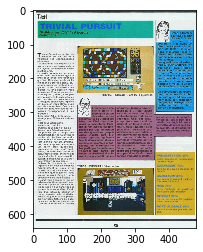

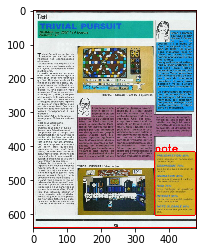

In [10]:
img = cv2.imread(sample_file)
plt.imshow(img)
for index, row in sample_data.iterrows():
    class_name, xmin, ymin, xmax, ymax = row['class_name'], int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.putText(img, class_name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA) 
plt.figure()
plt.imshow(img)

### Recognition and data expension

In [11]:
cv2.setUseOptimized(True)  # Enables the optimized code.

#### Example

Processing Selective Search...


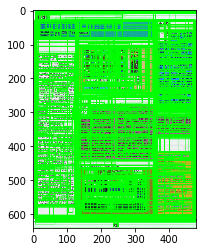

In [12]:
# We are using selective search to find potential areas of interest.
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()  # Uses optimized selective search (https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)
img = cv2.imread(sample_file)
ss.setBaseImage(img)
print("Processing Selective Search...")
ss.switchToSelectiveSearchFast()
rects = ss.process()
img_out = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(img_out)

#### All

In [13]:
train_images = []
train_labels = []

In [14]:
# Uses optimized selective search (https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [15]:
def get_iou(bb1, bb2):  # Intersection over Union (IoU) (https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
    # Basically, Area of Intersection / Area of Union...
    # bb1, bb2: {xmin, ymin, xmax, ymax}
    assert bb1['xmin'] < bb1['xmax']
    assert bb1['ymin'] < bb1['ymax']
    assert bb2['xmin'] < bb2['xmax']
    assert bb2['ymin'] < bb2['ymax']

    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
# Loop over each image
for index, row in tqdm(files.iterrows(), total=num_files, desc="Iterating through files..."):
    file = row[0]
    data = df.loc[df['file_name'] == file]
    img = cv2.imread(file)
    
    # Set image as the base for selective search
    ss.setBaseImage(img)
    
    # Initialising fast selective search and getting proposed regions
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    img_out = img.copy()
    
    classes_counter = defaultdict(int)  # As stated, we need an uniform sample between classes
    
    # Iterate over the first N results of selective search
    # Calculate IOU of proposed region and annoted region
    used = False  # Check if that bbox is used as a class example
    
    # For each rectangle in the results of selective search
    for i, rect in enumerate(tqdm(rects, desc="Iterating through rectangles...", leave=False)):
        if i < N:  # We don't want to waste ressources on too many possibilities.
            x, y, w, h = rect
            rect_bbox = {'xmin': x, 'xmax': x + w, 'ymin': y, 'ymax': y + h}
            
            # For each bbox within the image
            for index, row in data.iterrows():
                ground_truth_bbox = {'xmin': int(row['xmin']), 'xmax': int(row['xmax']),
                                     'ymin': int(row['ymin']), 'ymax': int(row['ymax'])}
                ground_truth_class_name = row['class_name']
                
                # Compare them
                iou = get_iou(ground_truth_bbox, rect_bbox)
                
                if iou > IOU_THRESHOLD and classes_counter[ground_truth_class_name] < MAX_SAMPLES:
                    img_sample = cv2.resize(img_out[y:y + h, x:x + w], (224,224), interpolation = cv2.INTER_AREA)  # Get the sample
                    train_images.append(img_sample)
                    train_labels.append(ground_truth_class_name)
                    classes_counter[ground_truth_class_name] += 1
                    used = True
                else:
                    continue
                    
            if not used and classes_counter['background'] < MAX_SAMPLES: # We can use that bbox as a background example!
                img_sample = cv2.resize(img_out[y:y + h, x:x + w], (224, 224), interpolation = cv2.INTER_AREA)  # Get the sample
                train_images.append(img_sample)
                train_labels.append('background')  # Background
                classes_counter['background'] += 1
        else:
            break

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/site-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/site-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/_weakrefset.py", line 119, in update
    for element in other:
  File "/home/stache/miniconda3/envs/project2/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data

In [17]:
train_images = np.array(train_images)  # Penser à sauvegarder cette merde...
train_labels = np.array(train_labels)

### Model
We are going to use transfer learning, aka "We do not have time to train a whole new model for a while so let's cut through an existing model and specialize it". https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9.

In [18]:
# Import pretrained original VGG16 model with ImageNet weights
vggmodel = VGG16(weights='imagenet', include_top=True)  # https://keras.io/applications/
vggmodel.summary()  # Pretty sure I can optimize that thing...











_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         


In [19]:
# Freeze first 15 layers
for i, layers in enumerate(vggmodel.layers[:15]):
    layers.trainable = False
    print("- Layer {} ({}) is not trainable anymore.".format(layers.get_config()['name'], i + 1))

- Layer input_1 (1) is not trainable anymore.
- Layer block1_conv1 (2) is not trainable anymore.
- Layer block1_conv2 (3) is not trainable anymore.
- Layer block1_pool (4) is not trainable anymore.
- Layer block2_conv1 (5) is not trainable anymore.
- Layer block2_conv2 (6) is not trainable anymore.
- Layer block2_pool (7) is not trainable anymore.
- Layer block3_conv1 (8) is not trainable anymore.
- Layer block3_conv2 (9) is not trainable anymore.
- Layer block3_conv3 (10) is not trainable anymore.
- Layer block3_pool (11) is not trainable anymore.
- Layer block4_conv1 (12) is not trainable anymore.
- Layer block4_conv2 (13) is not trainable anymore.
- Layer block4_conv3 (14) is not trainable anymore.
- Layer block4_pool (15) is not trainable anymore.


In [20]:
# Add a {number of classes} unit softmax dense layer
predictions = Dense(len(set(train_labels)), activation="softmax")(vggmodel.layers[-2].output)  # Maybe not all labels
model = Model(input = vggmodel.input, output = predictions)

/home/stache/miniconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Compile the model using Adam optimizer with learning rate of 0.001
# We are using categorical_crossentropy as loss since the output of the model is categorical
opt = Adam(lr=0.0001)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
________

In [22]:
# One-hot encoding: Basically "unique-fy-ish" each class.
# https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
# from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
        
lenc = MyLabelBinarizer()

In [23]:
mlb = MultiLabelBinarizer()

In [24]:
chosen_binarizer = lenc
train_labels_fit = chosen_binarizer.fit_transform(train_labels)
# train_labels_fit = chosen_binarizer.fit_transform([train_labels])  # For mlb
chosen_binarizer.classes_

array(['article', 'article_non_jeu', 'background', 'concours',
       'contenu_editorial', 'couverture', 'dossier', 'logo', 'message',
       'news', 'note', 'preview', 'pub_double', 'pub_encart', 'pub_image',
       'pub_jeu', 'pub_materiel_info', 'pub_non_jeu', 'pub_pleine_page',
       'pub_produits_mag', 'pub_services', 'pub_texte', 'publicite',
       'soluce', 'supplements', 'test'], dtype='<U17')

In [25]:
# Test and train set, yay.
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_fit, test_size=0.10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3850, 224, 224, 3) (428, 224, 224, 3) (3850, 26) (428, 26)


In [26]:
# Dataset augmentation
# This may not be needed following some magazines, as we do not often have rotated texts...
# ... Or do we? Anyway it applies for the pictures so there's that.
imgdatagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = imgdatagen.flow(x=X_train, y=y_train)
imgdatagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_data = imgdatagen.flow(x=X_test, y=y_test)

In [27]:
# We want checkpoints because losing training suckz lolz. https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)

# If we are not doing any progress, stops the whole thing. https://keras.io/callbacks/#earlystopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [28]:
# FINALLY train the model. https://keras.io/models/sequential/#fit_generator
hist = model.fit_generator(generator=train_data, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                           verbose=1, validation_data=test_data,
                           validation_steps=2, callbacks=[checkpoint, early])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 133s 13s/step - loss: 1.5221 - acc: 0.6594 - val_loss: 1.0026 - val_acc: 0.7344

Epoch 00001: val_loss improved from inf to 1.00263, saving model to ../data/work/checkpoint_01.h5
Epoch 2/10
10/10 [==============================] - 120s 12s/step - loss: 1.2994 - acc: 0.6688 - val_loss: 1.1250 - val_acc: 0.7188

Epoch 00002: val_loss did not improve from 1.00263
Epoch 3/10
10/10 [==============================] - 123s 12s/step - loss: 1.2777 - acc: 0.6562 - val_loss: 0.8763 - val_acc: 0.7188

Epoch 00003: val_loss improved from 1.00263 to 0.87633, saving model to ../data/work/checkpoint_03.h5
Epoch 4/10
10/10 [==============================] - 123s 12s/step - loss: 0.9854 - acc: 0.7094 - val_loss: 0.9336 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.87633
Epoch 5/10
10/10 [==============================] - 128s 13s/step - lo

### Moment of (ground) truth

#### Visualization

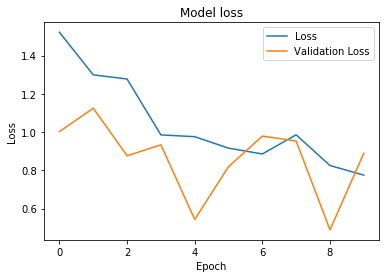

In [29]:
# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [49]:
print("Final loss: {}".format(hist.history['loss'][-1]))

Final loss: 0.7752091825008393


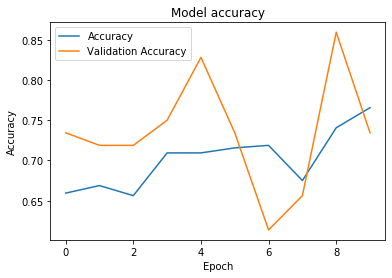

In [30]:
# Accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [50]:
print("Final loss: {}".format(hist.history['acc'][-1]))

Final loss: 0.765625


#### Testing

/home/stache/miniconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


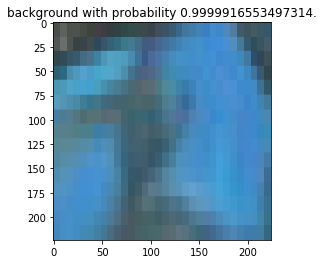

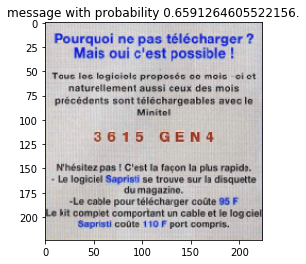

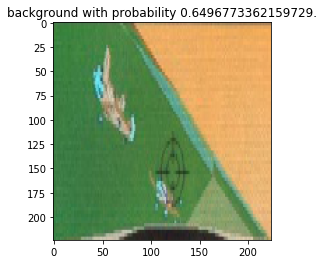

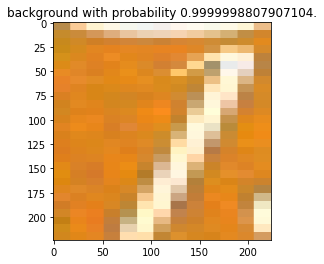

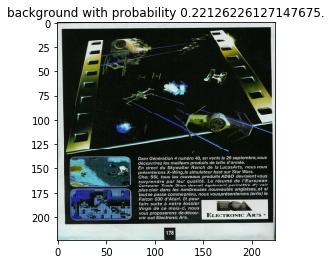

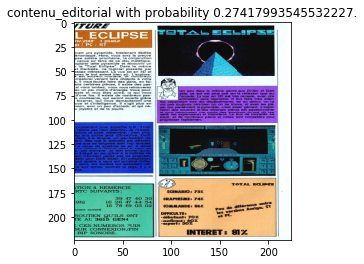

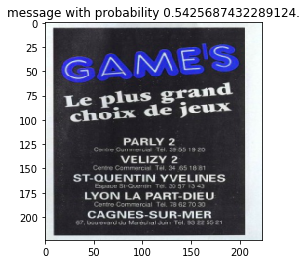

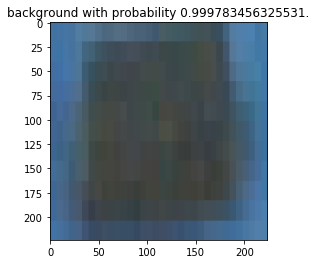

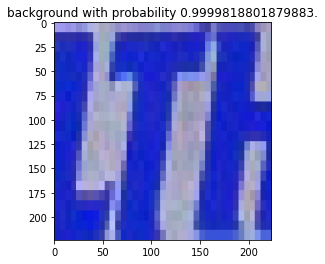

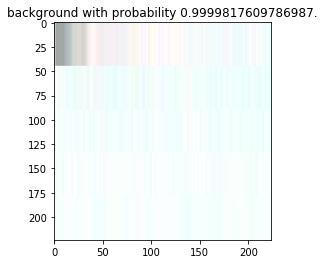

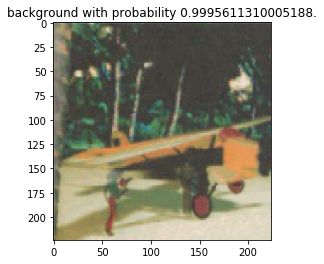

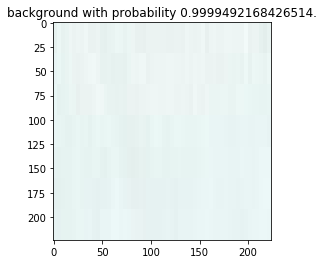

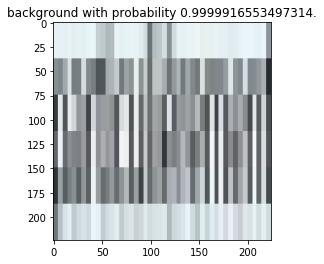

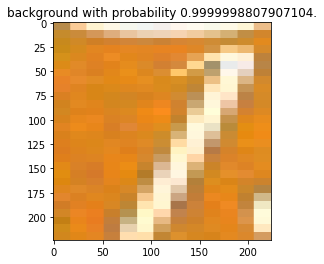

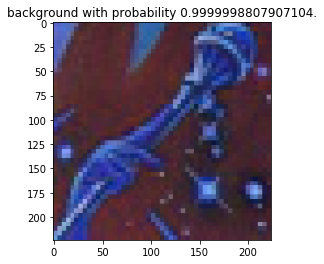

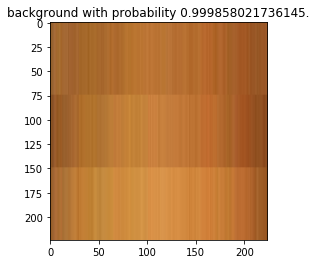

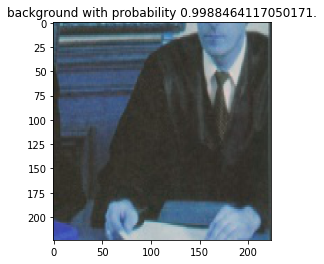

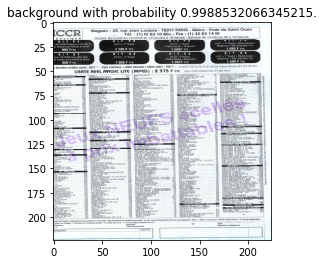

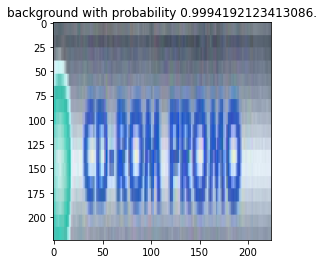

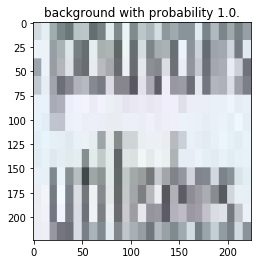

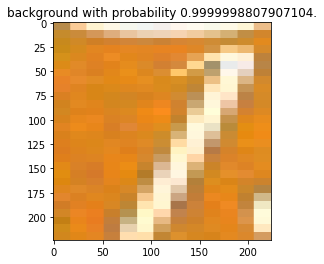

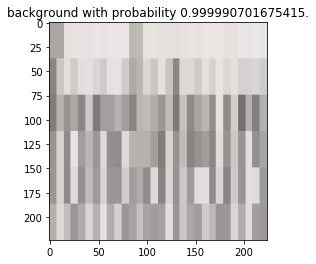

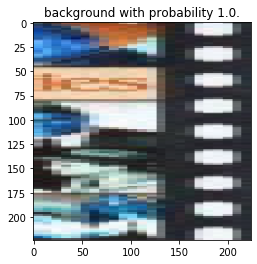

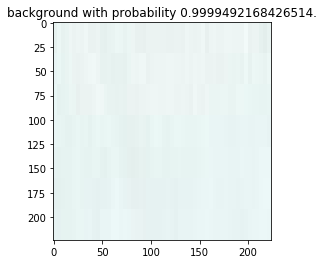

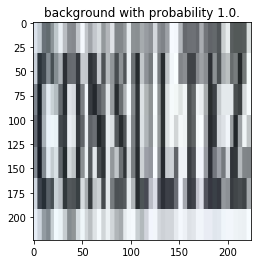

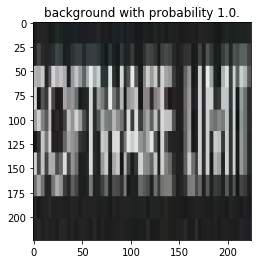

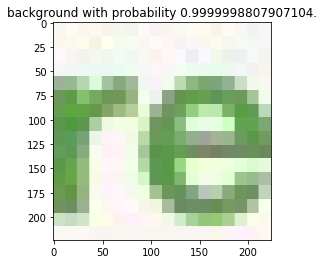

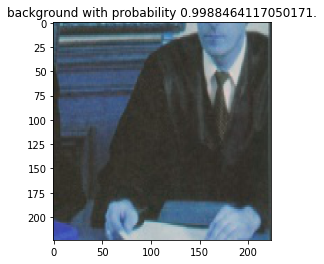

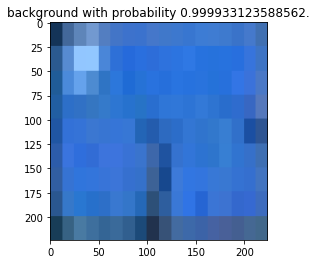

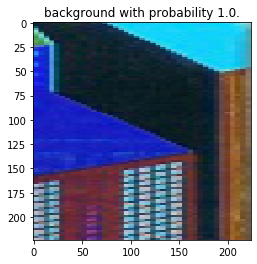

In [31]:
for i in range(30):
    test_img = X_test[random.randint(0, num_files)]
    plt.figure()
    test_out = np.expand_dims(test_img, axis=0)
    test_out = model.predict(test_out)
    guess = chosen_binarizer.classes_[test_out.argmax()]
    guess_probability = test_out.max()
    plt.title("{} with probability {}.".format(guess, guess_probability))
    plt.imshow(test_img)

### Page recognition

In [43]:
sample_row = files.sample(1, random_state=SEED * 1337)
sample_file = sample_row.iloc[0, 0]
sample_data = df.loc[df['file_name'] == sample_file]
sample_data

,file_name,class_name,xmin,ymin,xmax,ymax
199,../data/gen4/gen4_038/gen4_038_215.jpg,contenu_editorial,1,1,238,638
200,../data/gen4/gen4_038/gen4_038_215.jpg,contenu_editorial,239,1,480,318
201,../data/gen4/gen4_038/gen4_038_215.jpg,article,1,1,239,640
202,../data/gen4/gen4_038/gen4_038_215.jpg,article,240,1,480,318
203,../data/gen4/gen4_038/gen4_038_215.jpg,test,1,1,237,640
204,../data/gen4/gen4_038/gen4_038_215.jpg,test,238,1,480,317
205,../data/gen4/gen4_038/gen4_038_215.jpg,note,317,180,468,307
206,../data/gen4/gen4_038/gen4_038_215.jpg,publicite,247,327,467,635
207,../data/gen4/gen4_038/gen4_038_215.jpg,pub_encart,247,327,467,635
208,../data/gen4/gen4_038/gen4_038_215.jpg,pub_texte,248,326,466,633


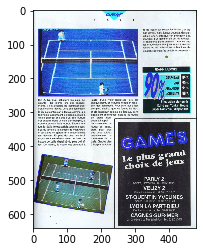

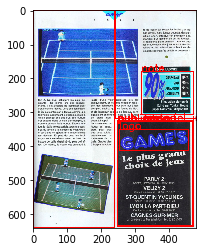

In [44]:
img = cv2.imread(sample_file)
plt.imshow(img)
for index, row in sample_data.iterrows():
    class_name, xmin, ymin, xmax, ymax = row['class_name'], int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.putText(img, class_name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA) 
plt.figure()
plt.imshow(img)

Found note with probability 0.6634103059768677.
Found publicite with probability 0.39301297068595886.
Found note with probability 0.4216606914997101.
Found publicite with probability 0.38699424266815186.
Found article with probability 0.16936059296131134.
Found message with probability 0.24776478111743927.
Found pub_texte with probability 0.5158350467681885.
Found publicite with probability 0.17201459407806396.
Found message with probability 0.2950690686702728.
Found message with probability 0.8935737013816833.
Found note with probability 0.32926881313323975.
Found note with probability 0.6024084091186523.
Found publicite with probability 0.3699111044406891.
Found note with probability 0.3313968777656555.
Found publicite with probability 0.40607699751853943.
Found note with probability 0.8042030930519104.
Found message with probability 0.6917142868041992.
Found message with probability 0.653291642665863.
Found message with probability 0.3134780824184418.
Found article with probability 

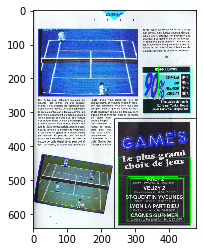

In [46]:
img = cv2.imread(sample_file)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(tqdm(ssresults)):
    if e < N:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model.predict(img)
        
        guess = chosen_binarizer.classes_[out.argmax()]
        guess_probability = out.max()
        
        if guess != "background":  # Eh...
            print("Found {} with probability {}.".format(guess, guess_probability))
            if guess_probability > IOU_THRESHOLD:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                cv2.putText(img, "{}".format(guess), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA) 
plt.figure()
plt.imshow(imout)